In [4]:
import os
import pandas as pd
import numpy as np

# Paths to data
data_folder = r"C:\Users\sejac\Desktop\BIEN471\csv_labels"
top_bins_path = r"C:\Users\sejac\Desktop\BIEN471\top_1000_bins_u_test.csv"

# Function to calculate z-scores with special handling for zero entries
def calculate_z_scores(data):
    # Exclude zeros when calculating mean and standard deviation
    non_zero_data = data[data != 0]
    mean = non_zero_data.mean()
    std = non_zero_data.std()

    # Avoid division by zero in case all non-zero values are the same
    if std == 0:
        return np.zeros_like(data)  # Return all zeros if standard deviation is zero

    # Calculate z-scores for non-zero values
    z_scores = (data - mean) / std
    z_scores[data == 0] = 0  # Keep zeros as zero
    return z_scores

# Load top 1000 bins
top_bins = pd.read_csv(top_bins_path)['Bin_ID']

# Initialize list to store all patients' data
all_patients_data = []

# Loop through all patient files
for filename in os.listdir(data_folder):
    if filename.endswith(".csv"):
        # Determine cancer label from filename
        if "_0_" in filename:
            label = 0  # Non-cancer
        elif "_1_" in filename:
            label = 1  # Cancer
        else:
            raise ValueError(f"Unexpected filename format: {filename}")
        
        # Load patient data
        file_path = os.path.join(data_folder, filename)
        patient_data = pd.read_csv(file_path)
        
        # Create unique Bin_ID (Chromosome + Start)
        patient_data['Bin_ID'] = patient_data['Chromosome'] + ":" + patient_data['Start'].astype(str)
        
        # Filter for top bins
        patient_data = patient_data[patient_data['Bin_ID'].isin(top_bins)]
        
        # Ensure consistent data length (after filtering for top bins)
        if len(patient_data) != len(top_bins):
            print(f"Inconsistent data length for {filename}. Skipping.")
            continue
        
        # Normalize Percent_Methylation using z-scores
        normalized_methylation = calculate_z_scores(patient_data['Percent_Methylation'].values)
        patient_data['Percent_Methylation'] = normalized_methylation
        
        # Set Bin_ID as the index for easier merging later
        patient_data = patient_data.set_index('Bin_ID')['Percent_Methylation']
        
        # Add label and patient identifier
        patient_data = patient_data.to_frame(name=filename).T  # Transpose for merging
        patient_data['Label'] = label  # Add label column
        
        # Append to list
        all_patients_data.append(patient_data)

# Combine all patient data into a single DataFrame
final_data = pd.concat(all_patients_data).reset_index(drop=True)

# Extract labels
labels = final_data['Label']
features = final_data.drop('Label', axis=1)

# Fill missing values with column mean (optional, but unlikely needed after z-normalization)
features.fillna(features.mean(), inplace=True)

print("Data normalization and preparation completed.")
print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")


Data normalization and preparation completed.
Features shape: (517, 1000), Labels shape: (517,)


In [5]:
from sklearn.model_selection import train_test_split

# Split into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Training set: (310, 1000)
Validation set: (103, 1000)
Test set: (104, 1000)


<h1>Random Forest<h1>

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.7379


In [10]:
from sklearn.metrics import classification_report

# Predict on the test set
y_test_pred = rf_model.predict(X_test)

# Compute accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Display results
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.7885
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        56
           1       0.75      0.81      0.78        48

    accuracy                           0.79       104
   macro avg       0.79      0.79      0.79       104
weighted avg       0.79      0.79      0.79       104



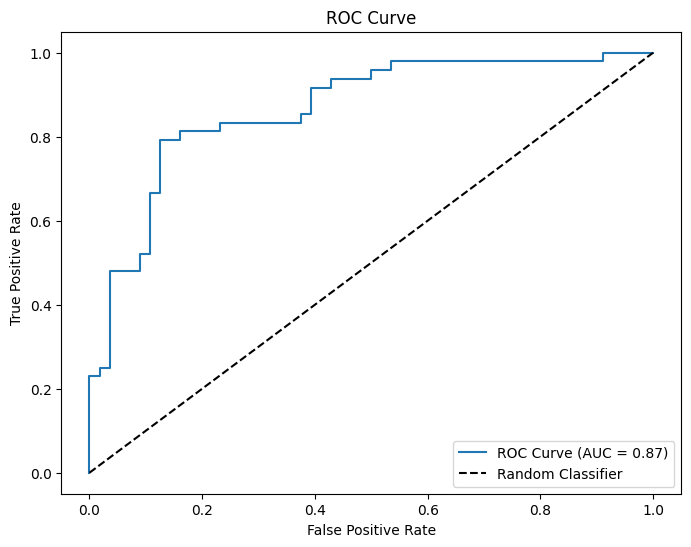

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve

# Compute probabilities and AUC
y_test_proba = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


<h1>XGBoost<h1>

In [9]:
# Initialize the XGBoost classifier with early stopping parameter
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    verbosity=1,
    random_state=42,
    early_stopping_rounds=10  # Specify early stopping directly in the model
)

# Fit the model
xgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],  # Validation set for early stopping
    verbose=True  # Print training progress
)

# Predict on validation set
y_val_pred = xgb_model.predict(X_val)
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]  # For ROC-AUC calculation

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")


[0]	validation_0-logloss:0.66459
[1]	validation_0-logloss:0.64869
[2]	validation_0-logloss:0.63207
[3]	validation_0-logloss:0.61833
[4]	validation_0-logloss:0.61189
[5]	validation_0-logloss:0.60597
[6]	validation_0-logloss:0.60392
[7]	validation_0-logloss:0.59642
[8]	validation_0-logloss:0.59467
[9]	validation_0-logloss:0.59264
[10]	validation_0-logloss:0.59126
[11]	validation_0-logloss:0.58707
[12]	validation_0-logloss:0.58794
[13]	validation_0-logloss:0.58619
[14]	validation_0-logloss:0.57809
[15]	validation_0-logloss:0.57510
[16]	validation_0-logloss:0.57359
[17]	validation_0-logloss:0.57283
[18]	validation_0-logloss:0.57814
[19]	validation_0-logloss:0.57399
[20]	validation_0-logloss:0.57131
[21]	validation_0-logloss:0.56765
[22]	validation_0-logloss:0.56938
[23]	validation_0-logloss:0.56952
[24]	validation_0-logloss:0.57201
[25]	validation_0-logloss:0.56801
[26]	validation_0-logloss:0.56702
[27]	validation_0-logloss:0.56540
[28]	validation_0-logloss:0.56829
[29]	validation_0-loglos

In [12]:
y_test_pred = xgb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
 

Test Accuracy: 0.8077


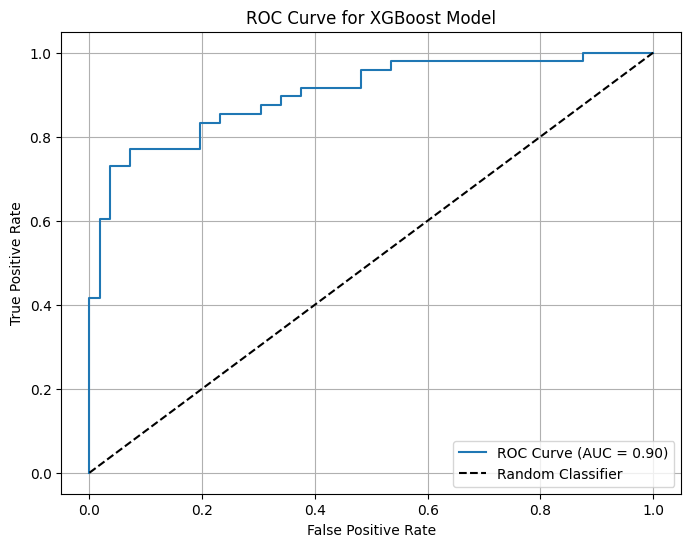

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute probabilities and AUC for the test set
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]  # Get probability for the positive class
roc_auc = roc_auc_score(y_test, y_test_proba)

# Calculate False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()


<h1>CNN<h1>

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Ensure features and labels are NumPy arrays
features = np.array(features) if not isinstance(features, np.ndarray) else features
labels = np.array(labels) if not isinstance(labels, np.ndarray) else labels

# Validate dimensions
print(features.shape)  # Should be (num_patients, num_features)
print(labels.shape)    # Should be (num_patients,)

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(517, 1000)
(517,)


In [16]:
class CancerClassifierCNN(nn.Module):
    def __init__(self, input_size):
        super(CancerClassifierCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32 * (input_size // 4), 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension: (batch_size, 1, input_size)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize Model, Loss, and Optimizer
input_size = X_train.shape[1]
model = CancerClassifierCNN(input_size=input_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training with Early Stopping
num_epochs = 30
patience = 5
min_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation Step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early Stopping Check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_model = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# Load the Best Model
model.load_state_dict(best_model)


Epoch 1/30, Train Loss: 1.1835, Val Loss: 0.6961
Epoch 2/30, Train Loss: 0.6241, Val Loss: 0.6715
Epoch 3/30, Train Loss: 0.5790, Val Loss: 0.7550
Epoch 4/30, Train Loss: 0.5645, Val Loss: 0.6710
Epoch 5/30, Train Loss: 0.4677, Val Loss: 0.6149
Epoch 6/30, Train Loss: 0.4762, Val Loss: 0.5890
Epoch 7/30, Train Loss: 0.3986, Val Loss: 0.6057
Epoch 8/30, Train Loss: 0.3670, Val Loss: 0.5867
Epoch 9/30, Train Loss: 0.2837, Val Loss: 0.6286
Epoch 10/30, Train Loss: 0.2154, Val Loss: 0.6028
Epoch 11/30, Train Loss: 0.1923, Val Loss: 0.6392
Epoch 12/30, Train Loss: 0.1735, Val Loss: 0.6285
Epoch 13/30, Train Loss: 0.1317, Val Loss: 0.6789
Early stopping triggered!


<All keys matched successfully>

Test Accuracy: 0.7500
ROC-AUC Score: 0.8171


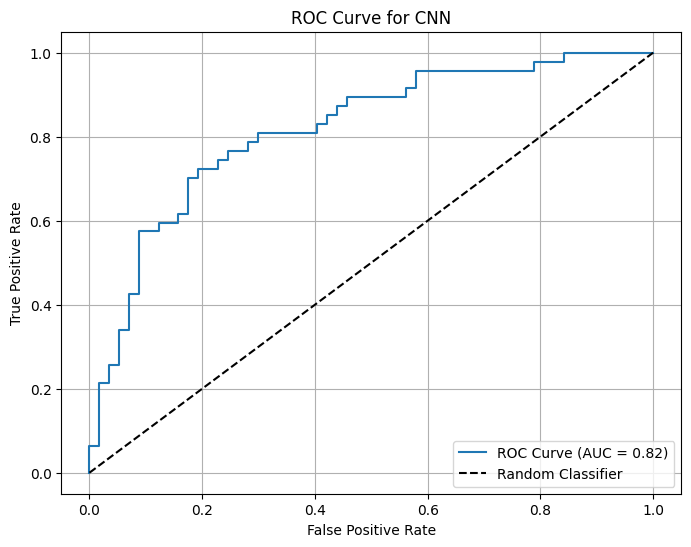

In [18]:
# Test Evaluation
model.eval()
y_true = []
y_pred = []
y_proba = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
        y_proba.extend(probs.tolist())

# Metrics
test_accuracy = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_proba)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc='lower right')
plt.grid()
plt.show()


<h1>MLP<h1>

In [22]:
# Define the MLP Model
class CancerClassifierMLP(nn.Module):
    def __init__(self, input_size):
        super(CancerClassifierMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [23]:
# Initialize Model, Loss, and Optimizer
input_size = X_train.shape[1]
model = CancerClassifierMLP(input_size=input_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training the MLP
num_epochs = 30
patience = 5
min_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation Step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_model = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

Epoch 1/30, Train Loss: 0.7527, Val Loss: 0.6582
Epoch 2/30, Train Loss: 0.6048, Val Loss: 0.6401
Epoch 3/30, Train Loss: 0.5074, Val Loss: 0.6494
Epoch 4/30, Train Loss: 0.3680, Val Loss: 0.7004
Epoch 5/30, Train Loss: 0.2202, Val Loss: 0.7718
Epoch 6/30, Train Loss: 0.1601, Val Loss: 0.8018
Epoch 7/30, Train Loss: 0.1269, Val Loss: 0.7708
Early stopping triggered!


Test Accuracy: 0.7115
ROC-AUC Score: 0.7675


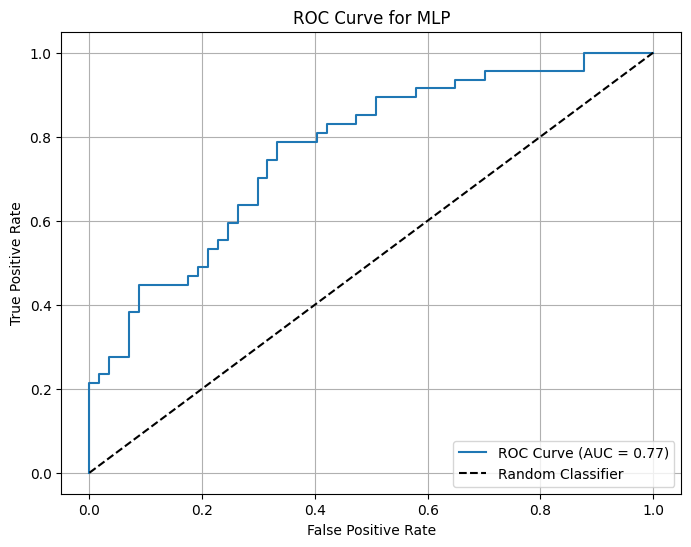

In [26]:
# Load the Best Model
model.load_state_dict(best_model)

# Test Evaluation
model.eval()
y_true = []
y_pred = []
y_proba = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
        y_proba.extend(probs.tolist())

# Metrics
test_accuracy = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_proba)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [30]:
# Use DataFrame format for X_test
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
X_test_df = pd.DataFrame(X_test, columns=features.columns)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test_df)[:, 1])
auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test_df)[:, 1])

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test_df)[:, 1])
auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test_df)[:, 1])
# Redefine and load CNN model
cnn_model = CancerClassifierCNN(input_size=X_test.shape[1])
cnn_model.load_state_dict(best_model)  # Load the best model from training
cnn_model.eval()
# CNN Predictions
y_proba_cnn = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = F.softmax(cnn_model(inputs), dim=1)[:, 1]
        y_proba_cnn.extend(outputs.numpy())
y_proba_cnn = np.array(y_proba_cnn)

# ROC for CNN
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_proba_cnn)
auc_cnn = roc_auc_score(y_test, y_proba_cnn)


C:\Users\sejac\Desktop\cancer\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\sejac\Desktop\cancer\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AttributeError: 'numpy.ndarray' object has no attribute 'columns'